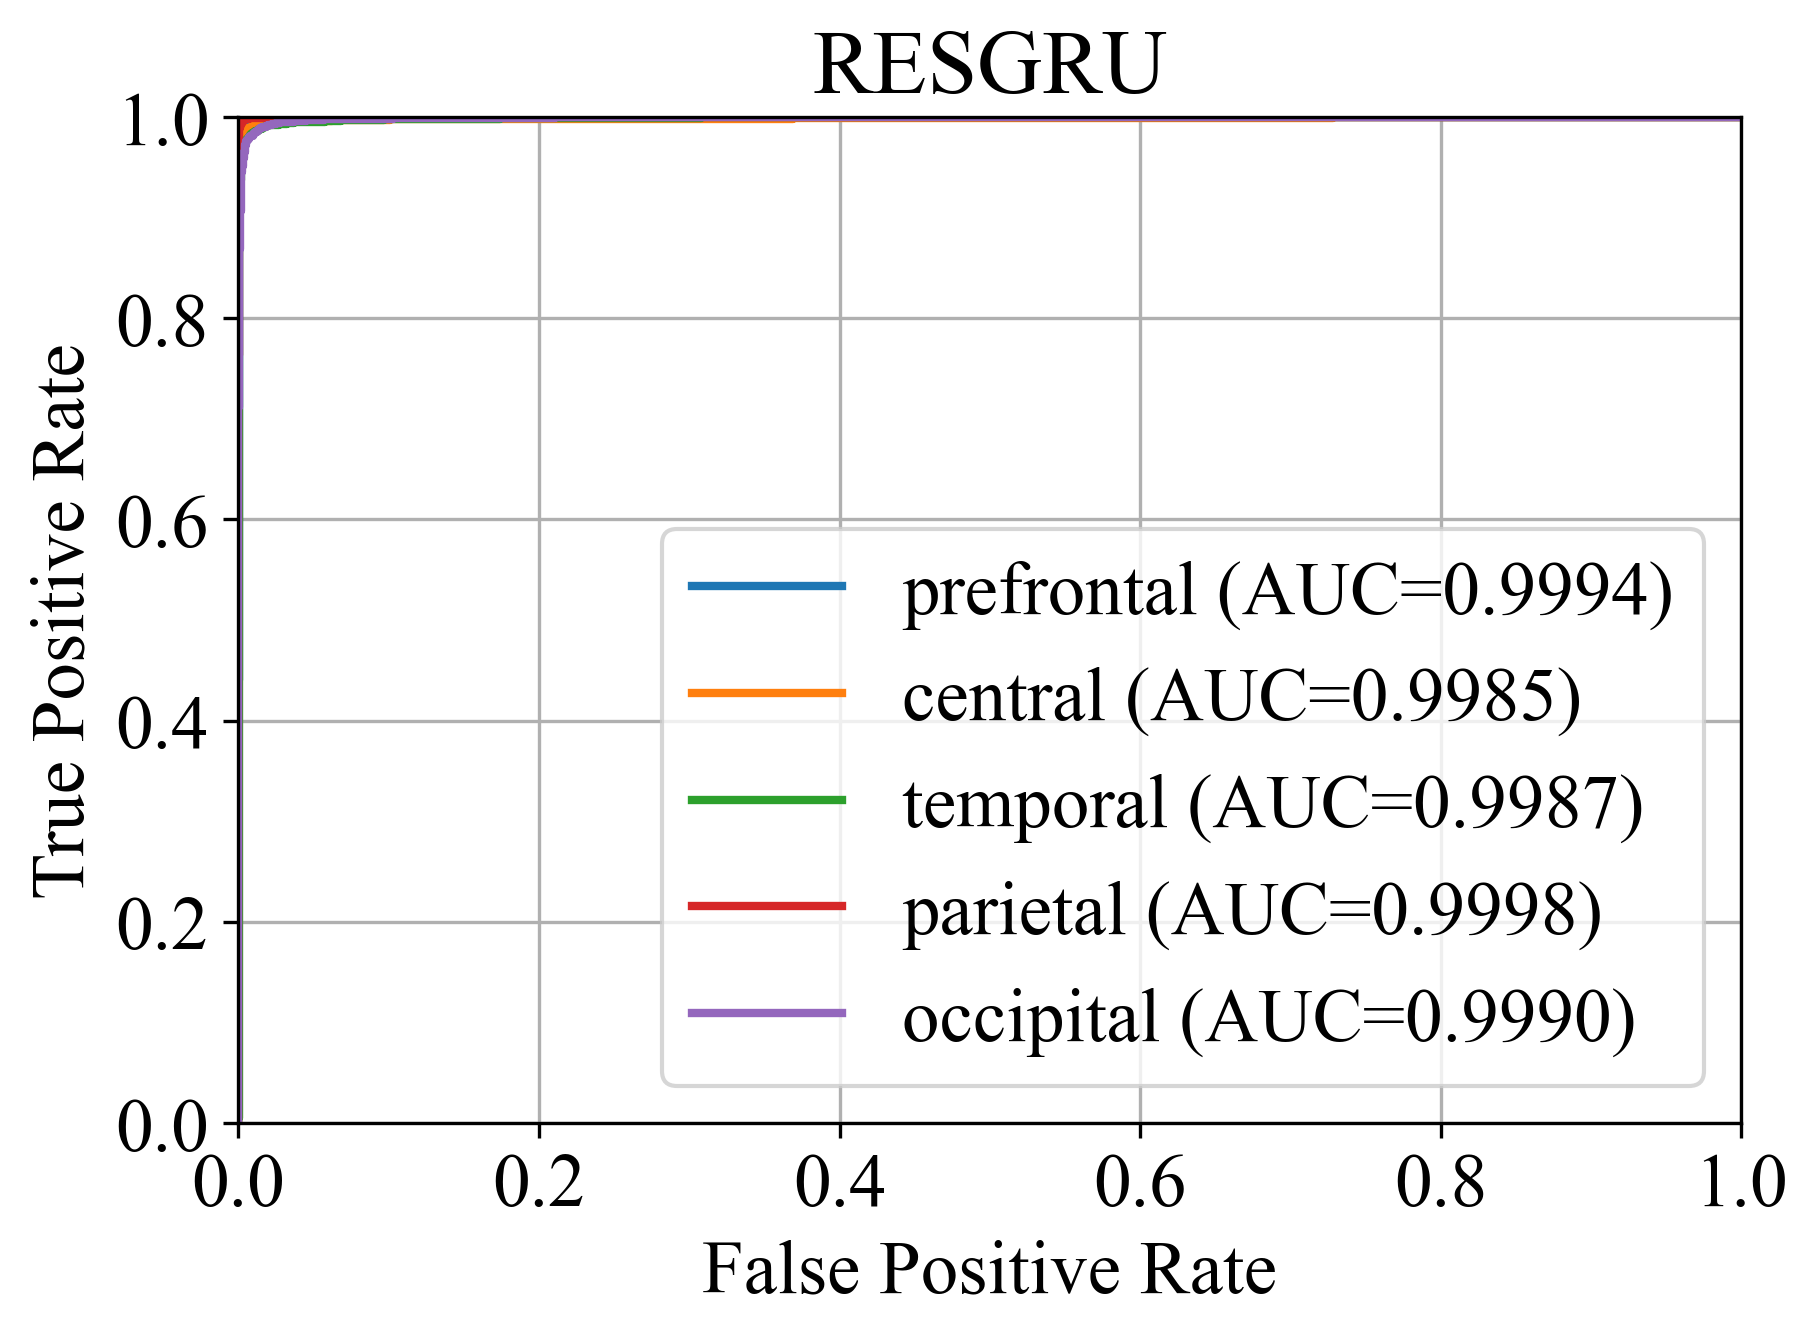

In [15]:
# 导入所需库
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, cohen_kappa_score

# 全局配置
MODEL_NAME = "resgru_tnb"
PARTITION = "prefrontal_central_temporal_parietal_occipital"
RESULT_DIR = f"result/{MODEL_NAME}"
TOTAL_FOLDS = 10

# 脑区列表
BRAIN_REGIONS = ['prefrontal', 'central', 'temporal', 'parietal', 'occipital']

# 设置字体参数（保持原有格式）
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

# AUC曲线绘制
plt.figure(dpi=300)
for region in BRAIN_REGIONS:
    csv_file_path = f"{RESULT_DIR}/{region}_labels_probs.csv"
    if not os.path.exists(csv_file_path):
        print(f"文件不存在: {csv_file_path}")
        continue
    
    df_region = pd.read_csv(csv_file_path)
    y_true = df_region['label'].values
    y_score = df_region['prob'].values
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{region} (AUC={roc_auc:.4f})')

# 设置图形属性（保持原有格式）
plt.xlim([0.00, 1.0])
plt.ylim([0.00, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RESGRU')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

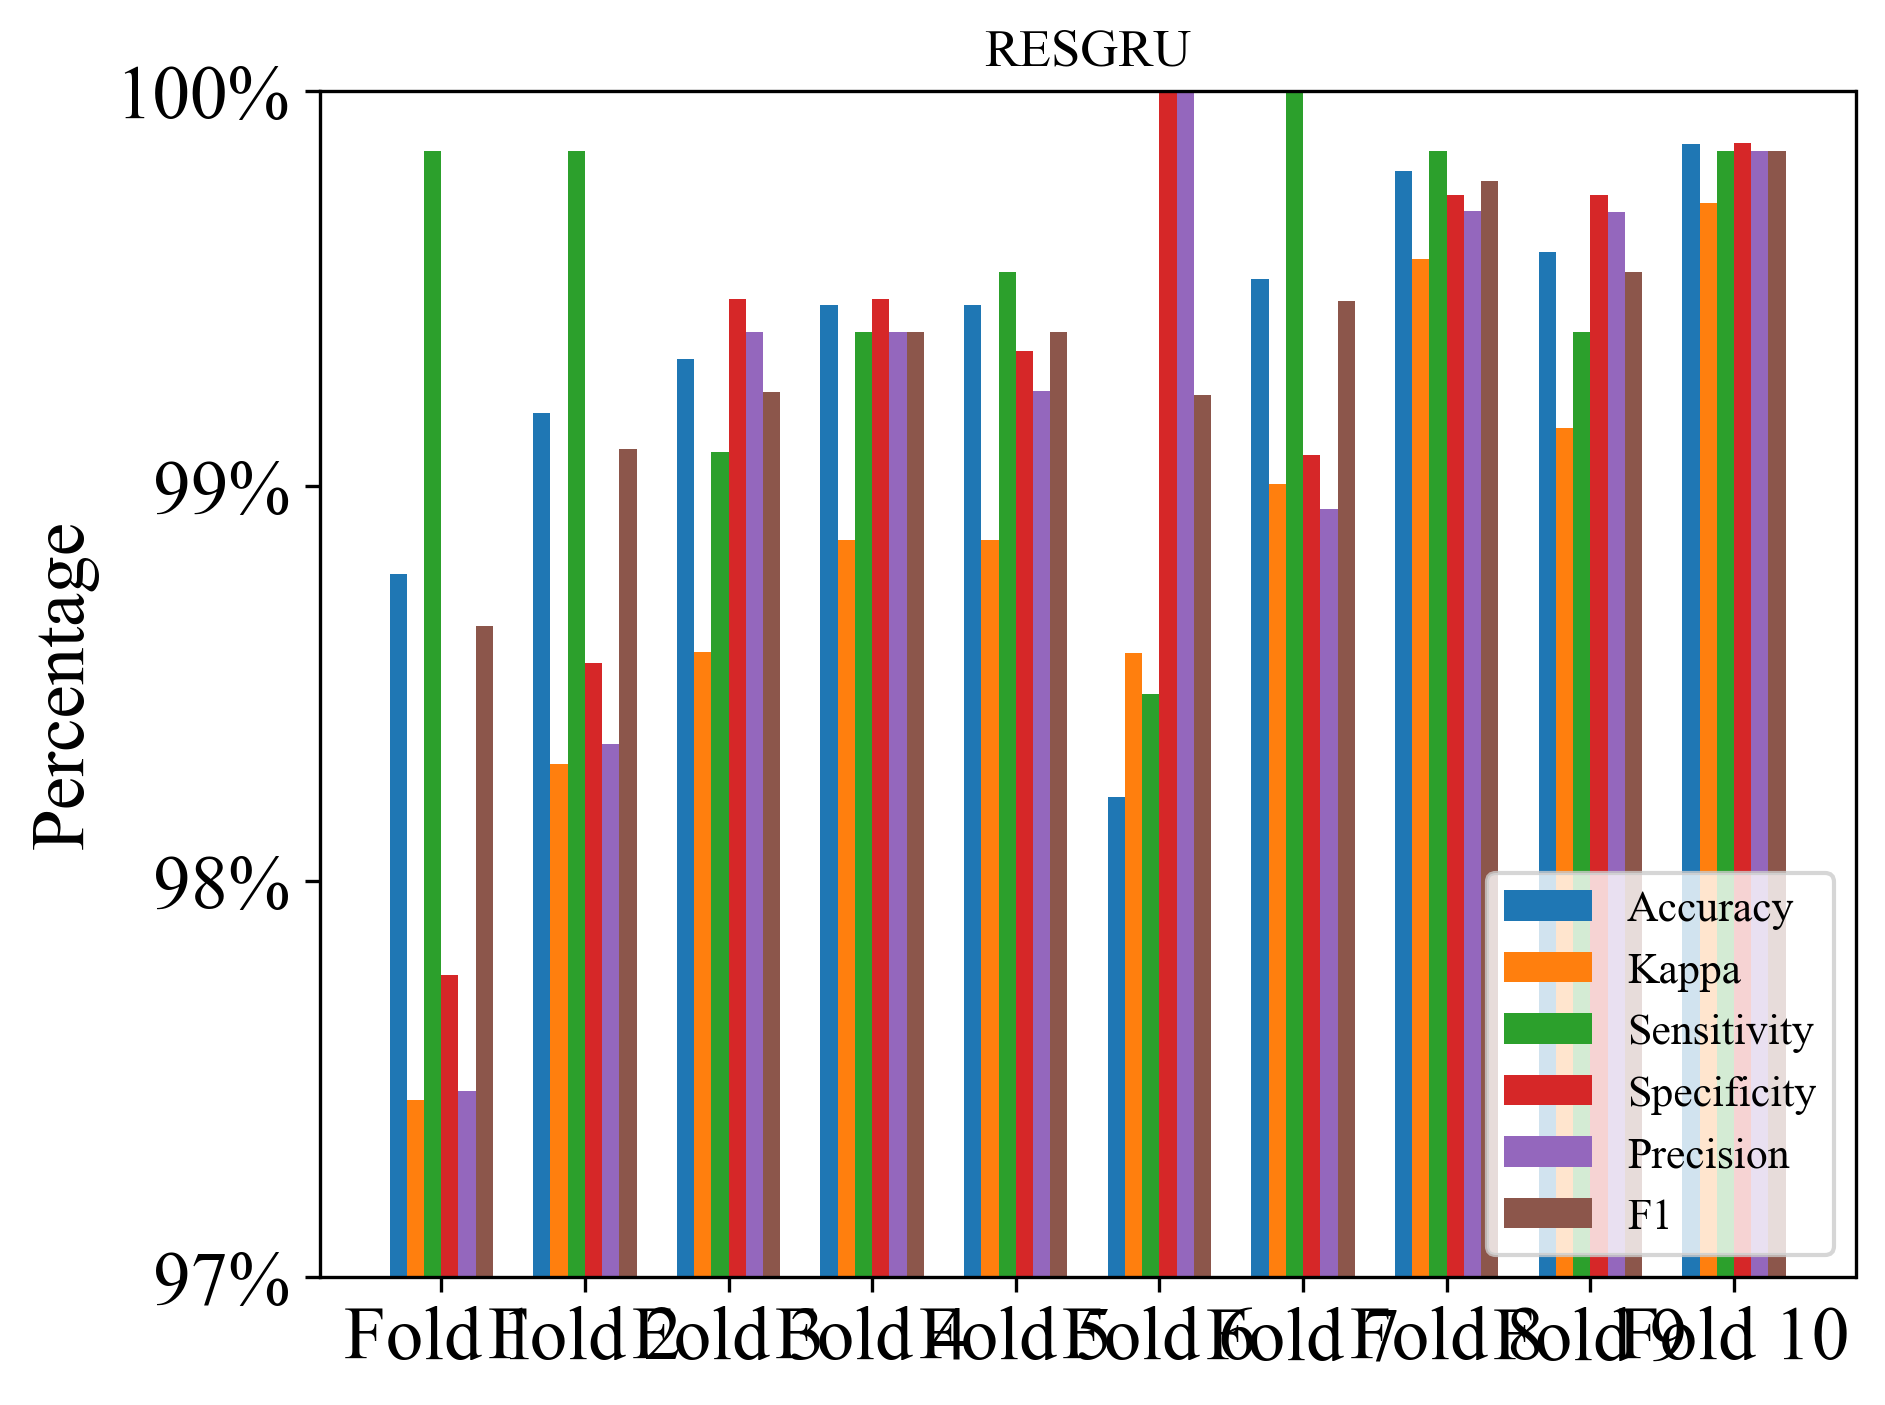

In [16]:
# 十折交叉验证各项指标柱状图
def plot_cross_validation_metrics(model_name=MODEL_NAME, partition=PARTITION):
    """绘制十折交叉验证各项指标柱状图"""
    # 读取指标数据
    metrics_csv_path = f"{RESULT_DIR.replace(MODEL_NAME, model_name)}/{partition}_metrics.csv"
    df_metrics = pd.read_csv(metrics_csv_path)
    
    # 排除平均值行，只保留折数数据
    df_fold_data = df_metrics[df_metrics['Fold'] != 'Mean']
    
    # 提取各项指标数据
    metrics_data = {
        'Accuracy': df_fold_data['Accuracy'].tolist(),
        'Kappa': df_fold_data['Kappa'].tolist(), 
        'Sensitivity': df_fold_data['Sensitivity'].tolist(),
        'Specificity': df_fold_data['Specificity'].tolist(),
        'Precision': df_fold_data['Precision'].tolist(),
        'F1': df_fold_data['F1'].tolist()
    }
    
    # 绘图参数
    x_positions = np.arange(len(df_fold_data))
    bar_width = 0.12
    
    # 创建图形
    fig, ax = plt.subplots(dpi=300)

    # 绘制各项指标的条形图
    metric_names = list(metrics_data.keys())
    for i, (metric_name, values) in enumerate(metrics_data.items()):
        offset = (i - 2.5) * bar_width
        ax.bar(x_positions + offset, values, bar_width, label=metric_name)
    
    # 设置字体和字号（保持原有格式）
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 10.5
    
    # 设置图形的标题
    ax.set_title(f'RESGRU')
    
    # 设置 Y 轴的标签
    ax.set_ylabel('Percentage')
    
    # 设置 X 轴的刻度和标签
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(df_fold_data))])
    
    # 设置 Y 轴的范围（保持原有范围）
    ax.set_ylim(0.97, 1.0)
    
    # 为了让 Y 轴刻度更清晰地显示百分比，自定义刻度
    y_ticks = np.arange(0.97, 1.001, 0.01)
    ax.set_yticks(y_ticks)
    # 将刻度标签格式化为百分比形式
    ax.set_yticklabels([f'{tick*100:.0f}%' for tick in y_ticks])
    
    # 添加图例（保持原有位置）
    ax.legend(loc='lower right')
    
    # 自动调整布局，防止标签重叠
    plt.tight_layout()
    
    # 保存图形（保持原有文件名格式）
    plt.savefig("1.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_fold_data

# 调用函数绘制图形
df_fold_data = plot_cross_validation_metrics()

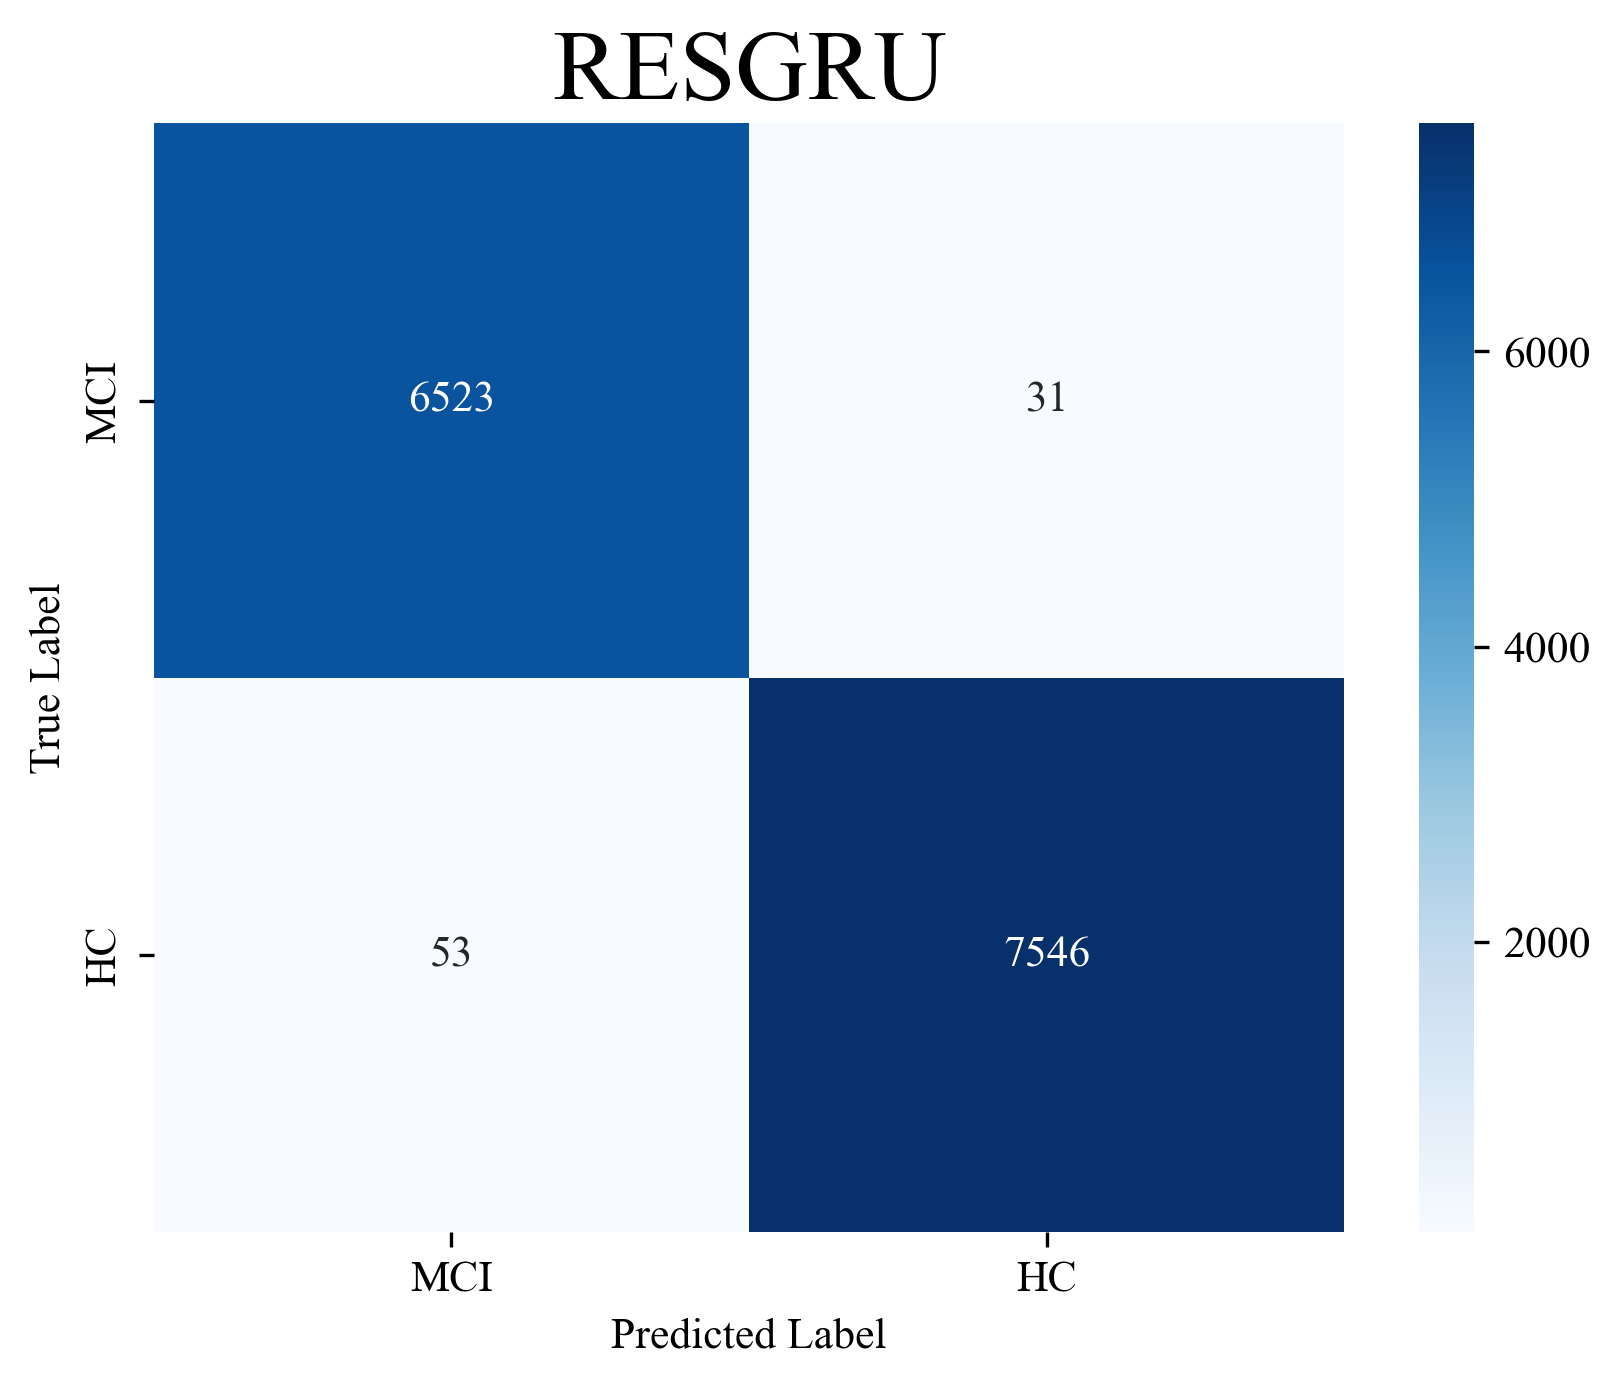

prefrontal_central_temporal_parietal_occipital 10折交叉验证平均测试集准确率: 0.9932 ± 0.0047, kappa值：0.9881, 灵敏度：0.9930, 特异度：0.9953, 查准率：0.9959, F1值：0.9945


In [17]:
# 混淆矩阵绘制和指标计算
def calculate_and_plot_confusion_matrix(model_name=MODEL_NAME, partition=PARTITION):
    """计算并绘制混淆矩阵，返回各项指标"""
    # 读取预测结果数据
    pred_csv_path = f"{RESULT_DIR.replace(MODEL_NAME, model_name)}/{partition}_labels_probs.csv"
    df_pred = pd.read_csv(pred_csv_path)
    
    # 提取真实标签和预测结果
    y_true = df_pred['label'].values
    y_pred = df_pred['prediction'].values
    
    # 计算混淆矩阵和相关指标
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    kappa_score = cohen_kappa_score(y_true, y_pred)
    
    # 从混淆矩阵计算各项指标
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # 灵敏度（召回率）
    specificity = tn / (tn + fp)  # 特异度
    precision = tp / (tp + fp)    # 查准率
    f1_score = 2 * precision * sensitivity / (precision + sensitivity)  # F1值
    
    # 绘制混淆矩阵（保持原有格式）
    def plot_confusion_matrix_heatmap(conf_matrix, class_names=['MCI', 'HC'], title='RESGRU'):
        plt.figure(dpi=300)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 20
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    # 绘制混淆矩阵
    plot_confusion_matrix_heatmap(conf_matrix)
    
    # 计算准确率统计（基于折数数据）
    if 'df_fold_data' in globals():
        accuracy_list = df_fold_data['Accuracy'].tolist()
        test_acc_mean = np.mean(accuracy_list)
        test_acc_std = np.std(accuracy_list)
    else:
        test_acc_mean = accuracy
        test_acc_std = 0.0
    
    # 打印结果（保持原有格式）
    print(f"{partition} {TOTAL_FOLDS}折交叉验证平均测试集准确率: {test_acc_mean:.4f} ± {test_acc_std:.4f}, "
          f"kappa值：{kappa_score:.4f}, 灵敏度：{sensitivity:.4f}, 特异度：{specificity:.4f}, "
          f"查准率：{precision:.4f}, F1值：{f1_score:.4f}")
    
    # 返回指标字典
    return {
        'accuracy': accuracy,
        'kappa': kappa_score,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': conf_matrix
    }

# 调用函数
metrics_results = calculate_and_plot_confusion_matrix()

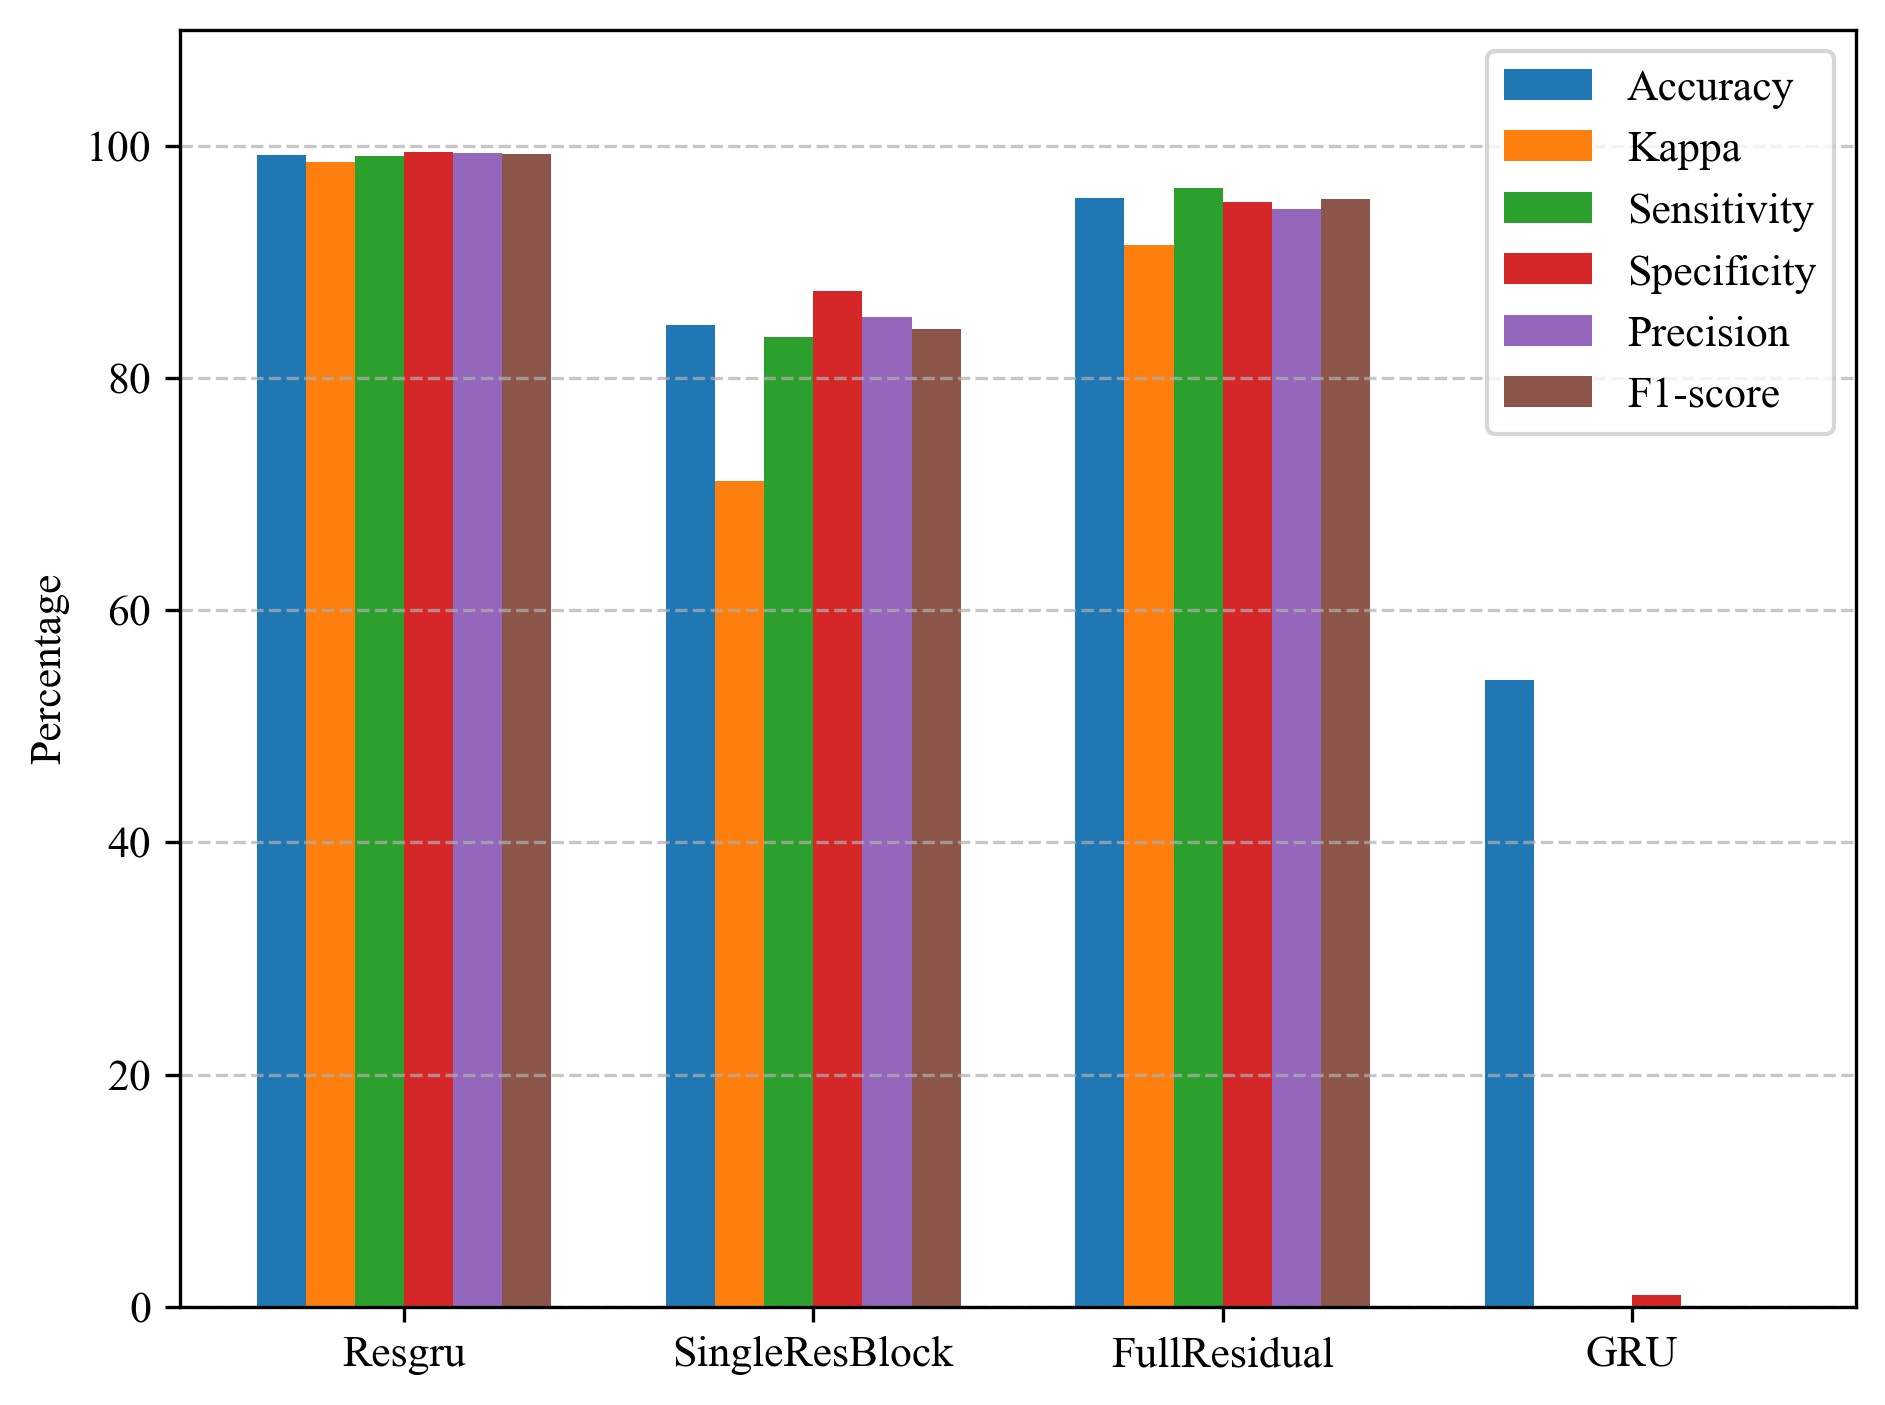

In [18]:
# 模型性能对比图
def plot_model_comparison():
    """绘制多个模型的性能对比图"""
    # 模型性能数据
    models = ['Resgru', 'SingleResBlock', 'FullResidual', 'GRU']
    accuracy = [99.23, 84.54, 95.52, 53.98]
    kappa = [98.60, 71.10, 91.43, 0]
    sensitivity = [99.14, 83.51, 96.39, 0]
    specificity = [99.44, 87.50, 95.15, 1]
    precision = [99.36, 85.20, 94.53, 0]
    f1_score = [99.25, 84.24, 95.44, 0]
    
    # 各项指标
    metrics = ['Accuracy', 'Kappa', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']
    values = [accuracy, kappa, sensitivity, specificity, precision, f1_score]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # 设置字体参数（保持原有格式）
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 10.5
    
    # 绘图参数
    x = np.arange(len(models))  # 模型位置
    width = 0.12  # 每个柱子的宽度
    
    # 创建图形
    plt.figure(dpi=300)
    
    # 绘制每种指标的柱状图
    for i, (metric, val) in enumerate(zip(metrics, values)):
        plt.bar(x + i * width, val, width, label=metric, color=colors[i])
    
    # 设置图表属性（保持原有格式）
    plt.xticks(x + width * 2.5, models)
    plt.ylabel('Percentage')
    plt.ylim(0, 110)
    # plt.title('Model Performance Comparison')  # 保持原有注释
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # 显示图形
    plt.show()

# 调用函数
plot_model_comparison()
